<a href="https://colab.research.google.com/github/jagadeesh-usd/receipt-expense-tracker-cv/blob/jaga-dev/notebooks/03_Train_YOLO_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automated Expense Extraction - Receipt Parsing Using YOLO and OCR  
### Train YOLOv8 for Receipt Detection
### Objective
Train a YOLOv8-Nano object detection model to localize three key fields on receipts:
1.  **Vendor** (Logo or Text)
2.  **Date**
3.  **Total Amount**

In [ ]:
# Install YOLOv8
!pip install ultralytics

#### Setup & Imports

In [2]:
import os
from ultralytics import YOLO
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    # Mount Google Drive (for Colab)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set DATA_PATH for Google Drive
    DATA_PATH = Path('/content/drive/MyDrive/data')
else:
    # Set DATA_PATH for local environment
    DATA_PATH = Path('../data')

# Define YOLO directory
YOLO_DIR = DATA_PATH / "processed/yolo_dataset"

# Verify the YOLO directory
print(f"YOLO Directory: {YOLO_DIR}")
print(f"{'Exists' if YOLO_DIR.exists() else 'Does not exist'}")


Mounted at /content/drive
YOLO Directory: /content/drive/MyDrive/data/processed/yolo_dataset
Exists


#### Model Training

In [4]:
# 1. Load the Model
model = YOLO('yolov8n.pt')
# model = YOLO('yolov8s.pt')

# 2. Train the Model with HIGH RESOLUTION
print("Starting High-Res Training...")
results = model.train(
    data=str(YOLO_DIR / "dataset.yaml"),
    epochs=50,
    imgsz=1280,
    rect=True,
    batch=4,
    project=str(DATA_PATH / "models"),
    name="yolo_receipts_highres_nano",
    exist_ok=True,
    patience=10 # Early stopping: stop training if no improvement for 10 epochs
)

print("High-Res Training Complete!")

print("Training Complete!")
print(f"Best Model Saved at: {DATA_PATH}/models/yolo_receipts_highres_nano/weights/best.pt")

Starting High-Res Training...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/data/processed/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_receipts_highres_nano, nbs=64, nms=False, opset=None, op

#### Data Visualization for YOLO Training Results

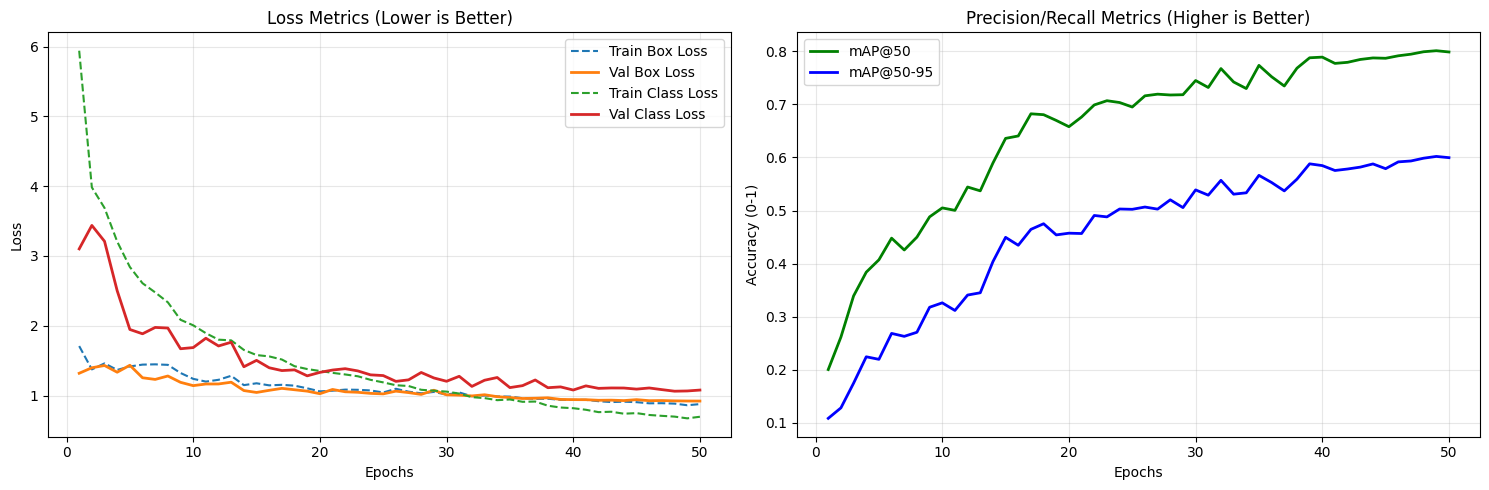

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# 1. Locate the Results CSV
run_dir = DATA_PATH / "models/yolo_receipts_highres_nano"
csv_path = run_dir / "results.csv"

if csv_path.exists():
    # Read Data
    df = pd.read_csv(csv_path)
    # YOLO column names often have spaces, strip them
    df.columns = df.columns.str.strip()

    # 2. Setup Plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # --- Plot 1: Training & Val Loss ---
    # Box Loss = How well it draws the box
    # Cls Loss = How well it knows "Vendor" vs "Total"
    axs[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='--')
    axs[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linewidth=2)
    axs[0].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='--')
    axs[0].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', linewidth=2)
    axs[0].set_title('Loss Metrics (Lower is Better)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # --- Plot 2: Mean Average Precision (mAP) ---
    # mAP50 = Accuracy at 50% Intersection over Union
    # mAP50-95 = Robust accuracy (averaged over many overlap thresholds)
    axs[1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='green', linewidth=2)
    axs[1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', color='blue', linewidth=2)
    axs[1].set_title('Precision/Recall Metrics (Higher is Better)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (0-1)')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print(f"Results file not found at {csv_path}. Did training finish?")


#### 1. Learning Dynamics (Loss Curves)
* **Convergence:** The **Box Loss** (localization error) and **Class Loss** (classification error) show a consistent downward trend over the 50 epochs. This confirms that the model is successfully learning to recognize receipt fields and refine its bounding boxes.
* **Generalization:** The validation loss closely tracks the training loss without diverging significantly. This indicates that the model is **generalizing well** to unseen data and is not suffering from major overfitting.

#### 2. Detection Performance (Precision & Recall)
* **mAP@50 (Mean Average Precision):** The sharp rise and stabilization of the mAP@50 metric demonstrates that the model can correctly identify Vendor, Date, and Total regions with high confidence.
* **Precision-Recall Balance:** The steady improvement in these metrics suggests the model has found an optimal balance between minimizing false positives (Precision) and capturing all relevant fields (Recall).

**Conclusion:** The training metrics indicate a stable and effective model, validated by high mAP scores, making it suitable for deployment in the Hybrid Inference Pipeline.

--- Confusion Matrix ---


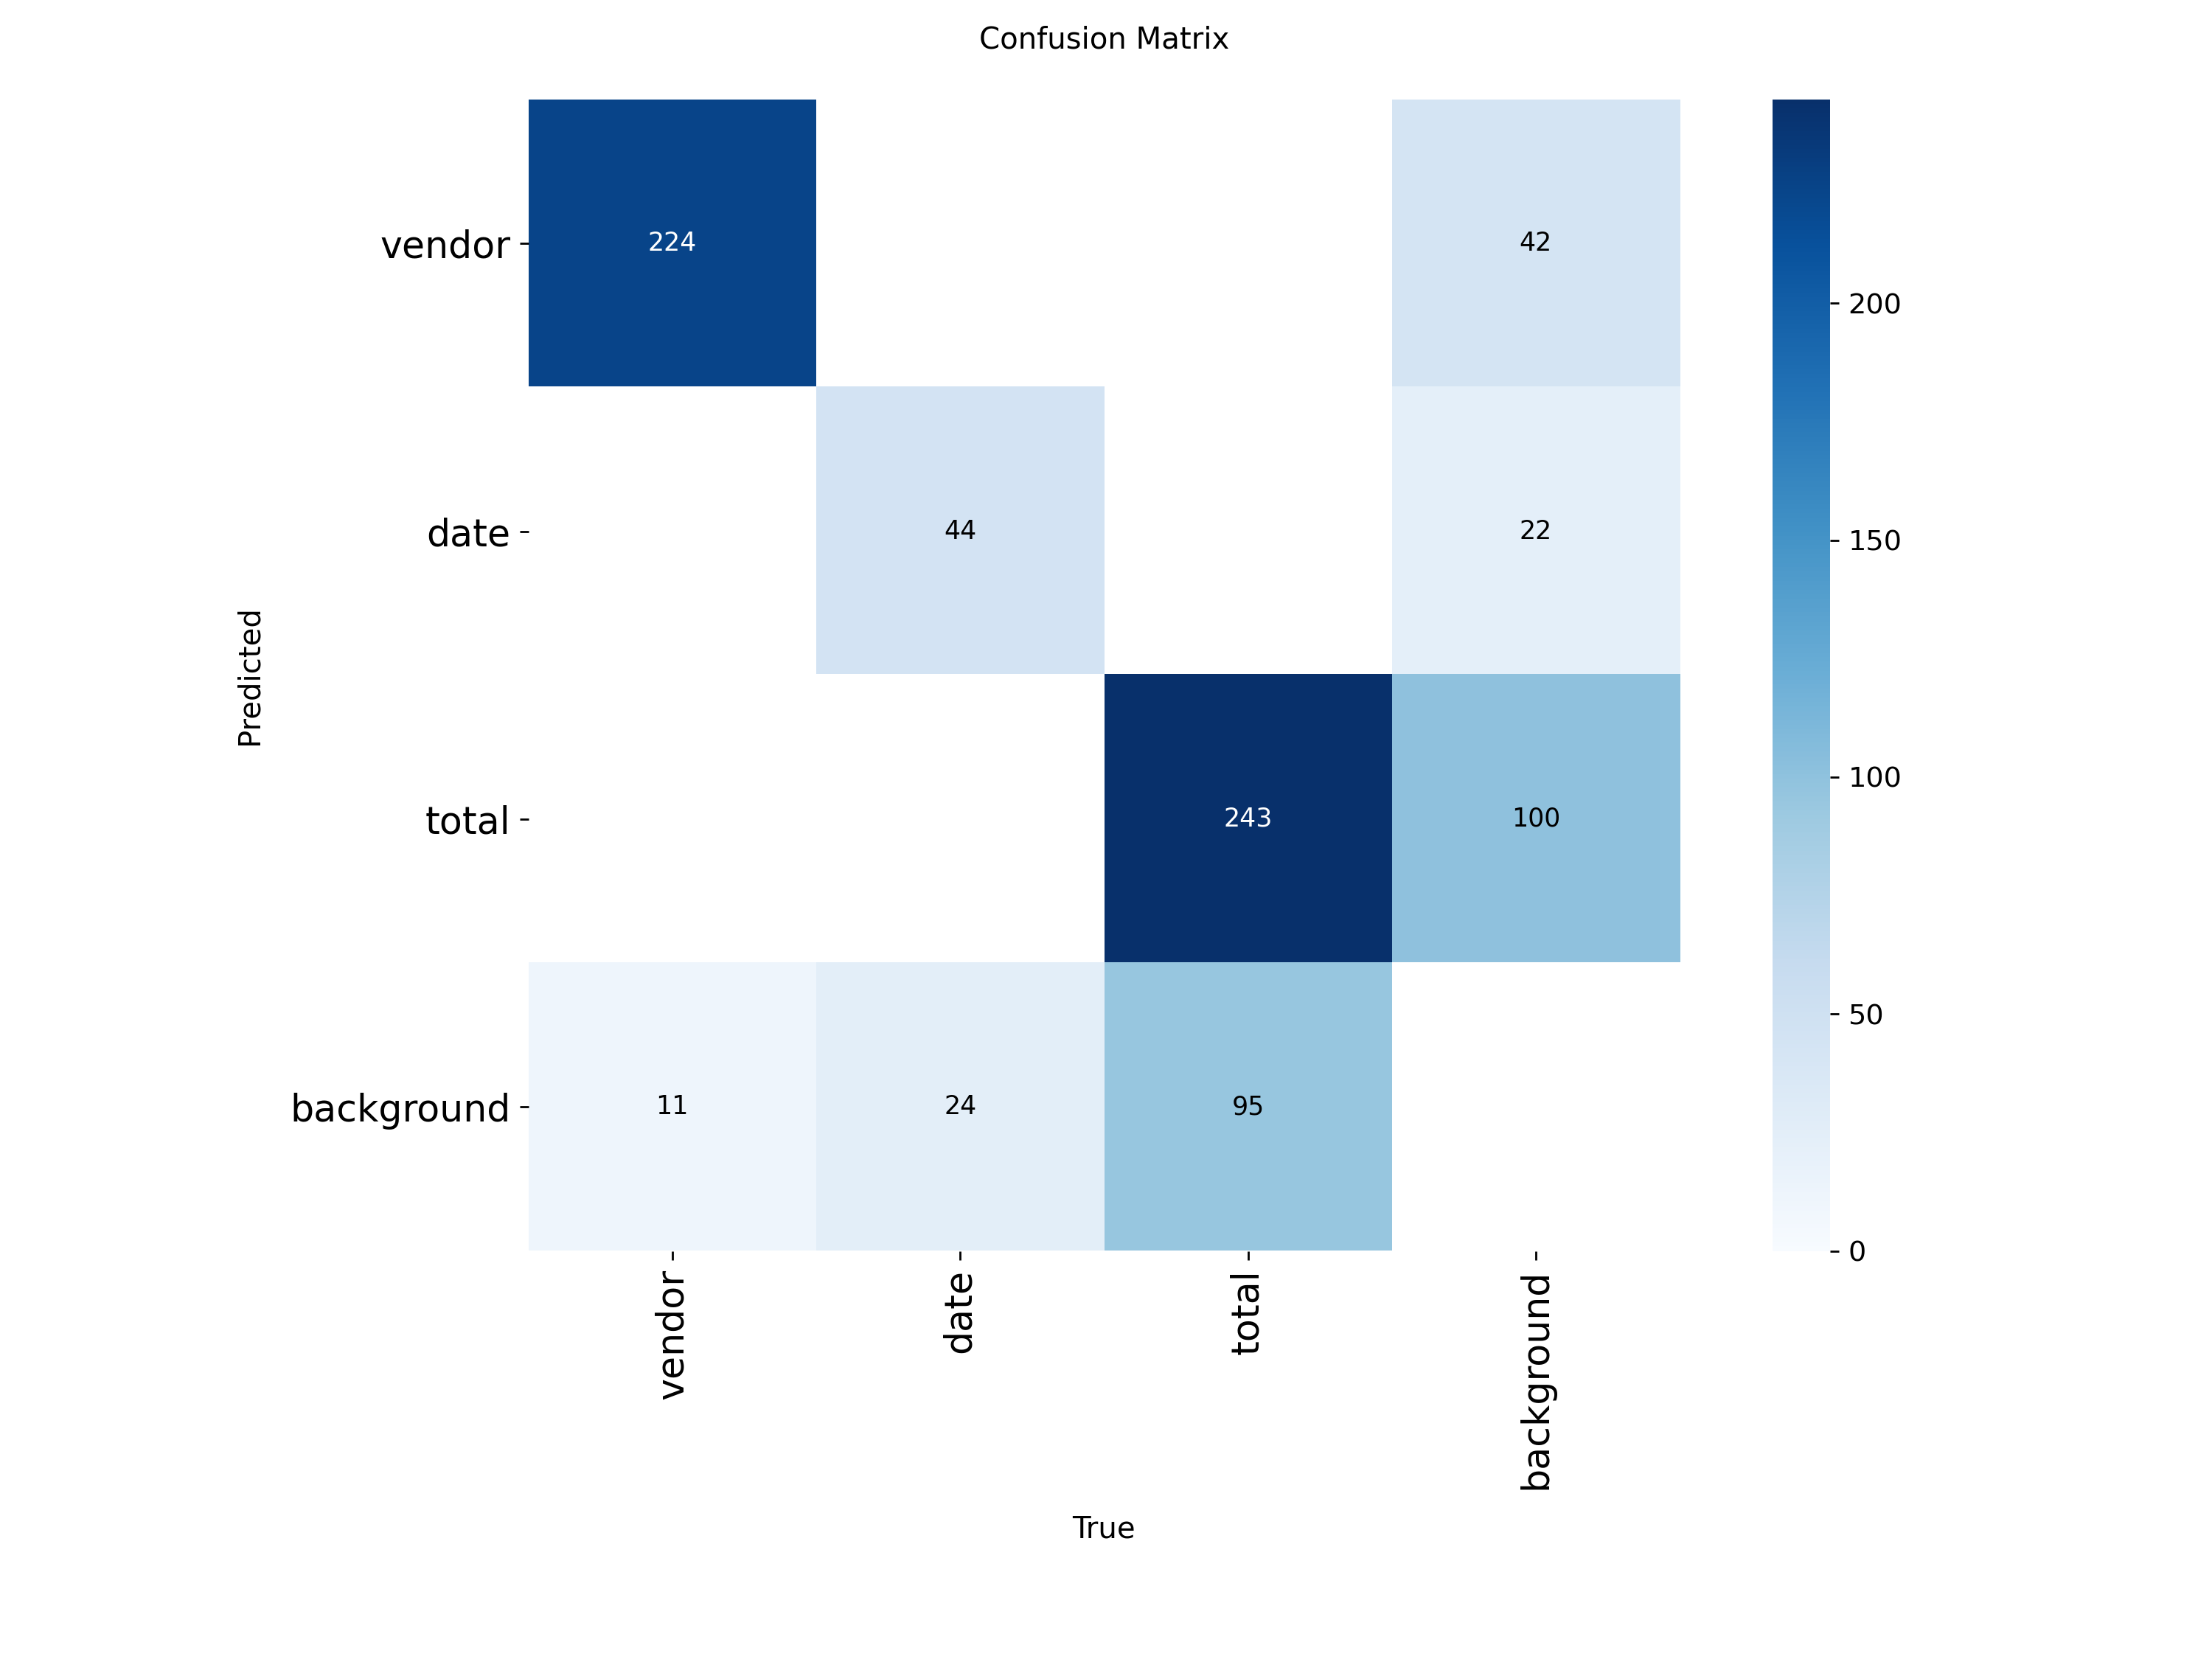

In [6]:
from IPython.display import Image, display

matrix_path = run_dir / "confusion_matrix.png"

if matrix_path.exists():
    print("--- Confusion Matrix ---")
    display(Image(filename=matrix_path, width=600))
else:
    print("Confusion matrix not found (requires validation run).")

#### Confusion Matrix Interpretation

- The model performs well for the **vendor** and **total** classes, with **224** and **243** correct predictions respectively.
- The **background** class shows moderate accuracy (**95** correct) but is often misclassified as **total** (**100 instances**).
- The **date** class has the weakest performance, with only **44** correct predictions and frequent confusion with the *total* and *background* classes.
- The most significant confusion occurs between **background → total**, indicating the model struggles to differentiate these two classes.
- Overall, the model appears biased toward predicting the **total** class, suggesting a need for improved class balance or feature separation.


--- Ground Truth (Left) vs. Predictions (Right) ---


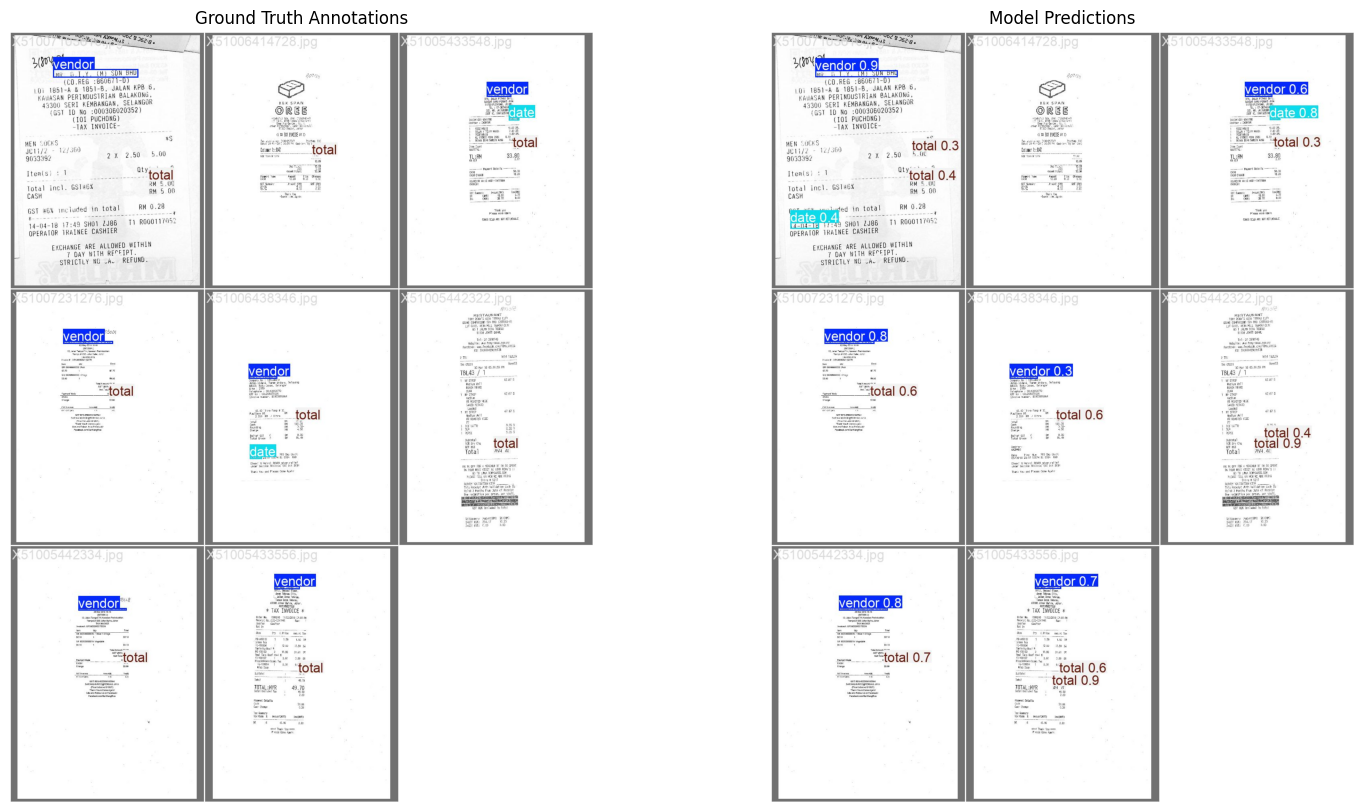

In [7]:
# Show Ground Truth
val_labels_path = run_dir / "val_batch0_labels.jpg"
# Show Predictions
val_pred_path = run_dir / "val_batch0_pred.jpg"

if val_pred_path.exists() and val_labels_path.exists():
    print("--- Ground Truth (Left) vs. Predictions (Right) ---")

    # Display side by side using matplotlib
    fig, ax = plt.subplots(1, 2, figsize=(18, 10))

    img_lbl = plt.imread(val_labels_path)
    img_pred = plt.imread(val_pred_path)

    ax[0].imshow(img_lbl)
    ax[0].set_title("Ground Truth Annotations")
    ax[0].axis('off')

    ax[1].imshow(img_pred)
    ax[1].set_title("Model Predictions")
    ax[1].axis('off')

    plt.show()

#### Visual Comparison: Ground Truth vs. Model Predictions

- The model accurately identifies **vendor** and **total** fields in most receipts, often with high confidence.
- **Date** extraction is inconsistent: predictions are sometimes missing or assigned low confidence.
- Some receipts show **multiple 'total' predictions**, indicating the model is over-detecting this class.
- Layout variation and low-contrast text appear to reduce prediction confidence on certain receipts.
- Overall, the model reliably detects key fields but needs improvement in:
  - Reducing duplicate predictions,
  - Improving **date** detection,
  - Handling receipts with unusual layouts or low visibility.


### Model Evaluation

After training the YOLOv8n model, we evaluate its performance using various metrics, including loss curves, Mean Average Precision (mAP), and confusion matrices. These metrics provide insights into how well the model learned to detect and classify objects within the receipts.

### Model Performance Summary – High-Resolution YOLOv8n (Receipts)

The `yolo_receipts_highres_nano` model was trained for **50 epochs** on high-resolution receipt images (`imgsz=1280`) with **3 classes**: `vendor`, `date`, and `total`. The best checkpoint `data/models/yolo_receipts_highres_nano/weights/best.pt`, achieved the following **validation metrics**:

**Overall performance (all classes)**

- **Precision (P):** 0.758  
- **Recall (R):** 0.751  
- **mAP@50:** **0.801**  
- **mAP@50–95:** **0.602**

**Per-class performance**

- **vendor**
  - Precision: 0.863  
  - Recall: 0.940  
  - **mAP@50:** 0.962  
  - **mAP@50–95:** 0.696  

- **date**
  - Precision: 0.683  
  - Recall: 0.634  
  - **mAP@50:** 0.696  
  - **mAP@50–95:** 0.539  

- **total**
  - Precision: 0.728  
  - Recall: 0.680  
  - **mAP@50:** 0.745  
  - **mAP@50–95:** 0.570  

#### Interpretation

- The model shows **strong overall detection quality** on receipts, with an mAP@50 of ~0.80 and solid recall across all classes.
- **`vendor`** fields are detected very reliably, with high precision and recall, indicating the model is robust at locating and classifying vendor names.
- **`total`** amounts also achieve good performance, supporting downstream use cases like automatic extraction of final bill totals.
- **`date`** is comparatively more challenging (lower recall and slightly lower mAP), which is expected due to small text size and varied date formats.  
  Targeted improvements (e.g., more diverse date samples, focused augmentations, or a slightly larger model variant) could further boost performance on this class.

Overall, the high-resolution YOLOv8n model is well-suited for **production-grade key-field detection on receipt images**, with room for refinement primarily around date extraction.
